In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import time
DTYPE_FP64 = jnp.float64

# Generate dense A matrices
def generate_dense_A(key, hidden_dim, input_dim):
    return jax.random.normal(key, (input_dim, hidden_dim, hidden_dim), dtype=DTYPE_FP64) / jnp.sqrt(hidden_dim)

# Generate data paths with irregular sampling
def generate_paths(key, seq_len, d_omega):
    key1, key2 = jax.random.split(key)
    regular_times = jnp.linspace(0, 60, seq_len + 1)
    perturbations = jax.random.uniform(key1, (seq_len - 1,), minval=-0.03, maxval=0.03)
    irregular_times = jnp.sort(regular_times.at[1:-1].add(perturbations))
    dt_irregular = jnp.diff(irregular_times)
    dW = jax.random.normal(key2, (seq_len, d_omega), dtype=DTYPE_FP64) * jnp.sqrt(dt_irregular[:, None])
    omega_observed = jnp.vstack([jnp.zeros((1, d_omega), dtype=DTYPE_FP64), jnp.cumsum(dW, axis=0)])
    return irregular_times, omega_observed, dW

# Naive Padé with scaling and squaring
def pade_naive(A, b, theta):
    I = jnp.eye(A.shape[0], dtype=A.dtype)
    A_norm = jnp.linalg.norm(A, ord=1)
    s_f = jnp.maximum(0.0, jnp.ceil(jnp.log2(A_norm / theta)))
    s = int(float(s_f))
    A_scaled = A / (2.0 ** s)
    powers = [I]
    for k in range(1, len(b)):
        powers.append(powers[-1] @ A_scaled)
    p = sum(b[j] * powers[j] for j in range(len(b)))
    q = sum(b[j] * ((-1)**j) * powers[j] for j in range(len(b)))
    R = jnp.linalg.solve(q, p)
    for _ in range(s):
        R = R @ R
    return R, s

# Padé functions
def pade_3(A):
    b = jnp.array([120, 60, 12, 1], dtype=A.dtype)
    theta_3 = 1
    return pade_naive(A, b, theta_3)

def pade_5(A):
    b = jnp.array([30240, 15120, 3360, 420, 30, 1], dtype=A.dtype)
    theta_5 = 1
    return pade_naive(A, b, theta_5)

def pade_7(A):
    b = jnp.array([17297280, 8648640, 1995840, 277200, 25200, 1512, 56, 1], dtype=A.dtype)
    theta_7 = 1
    return pade_naive(A, b, theta_7)

def pade_9(A):
    b = jnp.array([17643225600, 8821612800, 2075673600, 302702400, 30270240, 2162160, 110880, 3960, 90, 1], dtype=A.dtype)
    theta_9 = 1
    return pade_naive(A, b, theta_9)

def pade_13(A):
    b = jnp.array([
        64764752532480000, 32382376266240000, 7771770303897600,
        1187353796428800, 129060195264000, 10559470521600,
        670442572800, 33522128640, 1323241920,
        40840800, 960960, 16380,
        182, 1
    ], dtype=A.dtype)
    theta_13 = 1
    return pade_naive(A, b, theta_13)

# Taylor series
def expm_taylor(A, order=26):
    I = jnp.eye(A.shape[0], dtype=A.dtype)
    R = I
    term = I
    for k in range(1, order+1):
        term = (term @ A) / k
        R = R + term
    return R

# Linear CDE
class LinearCDE:
    def __init__(self, input_dim, hidden_dim, A_matrices):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.A_matrices = A_matrices

    @staticmethod
    def build_generators(A_matrices, delta_omega, g_scale=1):
        G_seq = jnp.einsum('ti,ijk->tjk', delta_omega, A_matrices)
        return g_scale * G_seq

    def expm_dense_batch_with_scaling(self, G_seq, method="pade", taylor_order=26, pade_type="13"):
        exp_seq = []
        scales = []
        for G in G_seq:
            if method=="pade":
                if pade_type=="3":
                    R, s = pade_3(G)
                elif pade_type=="5":
                    R, s = pade_5(G)
                elif pade_type=="7":
                    R, s = pade_7(G)
                elif pade_type=="9":
                    R, s = pade_9(G)
                elif pade_type=="13":
                    R, s = pade_13(G)
                else:
                    raise ValueError("Unknown Padé type")
                scales.append(s)
            elif method=="taylor":
                R = expm_taylor(G, order=taylor_order)
            else:
                raise ValueError("Unknown method")
            exp_seq.append(R)
        if method=="pade":
            return jnp.stack(exp_seq), jnp.array(scales, dtype=jnp.int32)
        else:
            return jnp.stack(exp_seq)

    @staticmethod
    def cumulative_prod_scan(exp_seq):
        return jax.lax.associative_scan(lambda x, y: x @ y, exp_seq[::-1])

    def forward(self, delta_omega, h0, method="pade", taylor_order=26, g_scale=1, pade_type="13"):
        G_seq = self.build_generators(self.A_matrices, delta_omega, g_scale=g_scale)
        if method=="pade":
            exp_seq, scales = self.expm_dense_batch_with_scaling(G_seq, method=method, taylor_order=taylor_order, pade_type=pade_type)
            cumulative_products = self.cumulative_prod_scan(exp_seq)
            h_final = cumulative_products[-1] @ h0
            return h_final, scales
        elif method=="taylor":
            exp_seq = self.expm_dense_batch_with_scaling(G_seq, method=method, taylor_order=taylor_order)
            cumulative_products = self.cumulative_prod_scan(exp_seq)
            h_final = cumulative_products[-1] @ h0
            return h_final
        else:
            raise ValueError("Unknown method")

# Scipy expm
def scipy_method(A_matrices, delta_omega, h0, g_scale=1):
    from scipy.linalg import expm
    import numpy as np
    h = np.array(h0)
    for t in range(delta_omega.shape[0]):
        G_seq = g_scale * np.einsum('i,ijk->jk', np.array(delta_omega[t]), np.array(A_matrices))
        h = expm(G_seq) @ h
    return jnp.array(h)

# Euler method
def euler_method(A_matrices, delta_omega, h0, num_substeps=100000, g_scale=1):
    I = jnp.eye(h0.shape[0], dtype=h0.dtype)
    def step(h, dW):
        dW_sub = dW / num_substeps
        G_sub = g_scale * jnp.einsum('i,ijk->jk', dW_sub, A_matrices)
        def substep(h_inner, _):
            return (I + G_sub) @ h_inner, None
        h_final, _ = jax.lax.scan(substep, h, None, length=num_substeps)
        return h_final, None
    h_final, _ = jax.lax.scan(step, h0, delta_omega)
    return h_final

# RK4 method
def rk4_method(A_matrices, delta_omega, h0, num_substeps=100, g_scale=1):
    I = jnp.eye(h0.shape[0], dtype=h0.dtype)
    def step(h, dW):
        dW_sub = dW / num_substeps
        G_sub = g_scale * jnp.einsum('i,ijk->jk', dW_sub, A_matrices)
        def substep(h_inner, _):
            K1 = G_sub @ h_inner
            K2 = G_sub @ (h_inner + 0.5*K1)
            K3 = G_sub @ (h_inner + 0.5*K2)
            K4 = G_sub @ (h_inner + K3)
            return h_inner + (K1 + 2*K2 + 2*K3 + K4)/6.0, None
        h_final, _ = jax.lax.scan(substep, h, None, length=num_substeps)
        return h_final, None
    h_final, _ = jax.lax.scan(step, h0, delta_omega)
    return h_final

# Experiment
key = jax.random.PRNGKey(42)
input_dim = 32
hidden_dim = 32
seq_len = 10
d_omega = input_dim
g_scale = 0.0000001

# Initialization
A_mats = generate_dense_A(key, hidden_dim, input_dim)
t_vals, omega_vals, delta_omega = generate_paths(key, seq_len, d_omega)
h0 = jnp.ones(hidden_dim, dtype=DTYPE_FP64)
model = LinearCDE(input_dim, hidden_dim, A_mats)

methods = [
    ("Padé 3", "3"),
    ("Padé 5", "5"),
    ("Padé 7", "7"),
    ("Padé 9", "9"),
    ("Padé 13", "13"),
    ("Scipy", None),
    ("Taylor 1", 1),
    ("Taylor 2", 2),
    ("Taylor 5", 5),
    ("Taylor 10", 10),
    ("Taylor 20", 20),
    ("Taylor 26", 26),
    ("Euler 10", 10),
    ("Euler 100", 100),
    ("RK4 10", 10),
    ("RK4 100", 100)
]

results = {}
for name, param in methods:
    t0 = time.time()
    if "Padé" in name:
        h, scales = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale)
    elif "Taylor" in name:
        h = model.forward(delta_omega, h0, method="taylor", taylor_order=int(param), g_scale=g_scale)
    elif "Euler" in name:
        h = euler_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
    elif "RK4" in name:
        h = rk4_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
    elif name=="Scipy":
        h = scipy_method(A_mats, delta_omega, h0, g_scale=g_scale)
    results[name] = (h, time.time() - t0)

# Compute Euler ground truth once
t0 = time.time()
h_euler_gt = euler_method(A_mats, delta_omega, h0, num_substeps=100000, g_scale=g_scale)
time_euler_gt = time.time() - t0

G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
G_norms = jnp.array([jnp.max(jnp.sum(jnp.abs(G), axis=0)) for G in G_seq])

# Print norms
print("\nNorms of generator matrices at each time step:")
for t, norm_val in enumerate(G_norms):
    print(f"t={t:3d}, ||G_t||_F = {norm_val:.6e}")

# Print results
print(f"\n{'Method':<20} {'Time (s)':<12} {'Relative Error':<15}")
print("-"*50)
for name, (h, t_elapsed) in results.items():
    rel_err = float(jnp.linalg.norm(h - h_euler_gt)/jnp.linalg.norm(h_euler_gt))
    print(f"{name:<20} {t_elapsed:<12.6f} {rel_err:<15.6e}")
print(f"{'Euler ground truth':<20} {time_euler_gt:<12.6f} {'0.00e+00':<15}")



Norms of generator matrices at each time step:
t=  0, ||G_t||_F = 8.088036e-05
t=  1, ||G_t||_F = 7.688697e-05
t=  2, ||G_t||_F = 7.602337e-05
t=  3, ||G_t||_F = 8.555067e-05
t=  4, ||G_t||_F = 7.620645e-05
t=  5, ||G_t||_F = 8.922001e-05
t=  6, ||G_t||_F = 6.571063e-05
t=  7, ||G_t||_F = 5.914674e-05
t=  8, ||G_t||_F = 6.506553e-05
t=  9, ||G_t||_F = 5.854599e-05

Method               Time (s)     Relative Error 
--------------------------------------------------
Padé 3               0.089165     2.128483e-11   
Padé 5               0.104202     2.128453e-11   
Padé 7               0.125261     2.128460e-11   
Padé 9               0.148362     2.128414e-11   
Padé 13              0.178966     2.128482e-11   
Scipy                0.015444     2.128502e-11   
Taylor 1             0.028839     2.809855e-10   
Taylor 2             0.029239     2.128457e-11   
Taylor 5             0.044661     2.128473e-11   
Taylor 10            0.052980     2.128473e-11   
Taylor 20            0.060351 

In [ ]:
import matplotlib.pyplot as plt

# Vary g_scale experiment
g_scales = jnp.logspace(-3, 1, 10)  # 0.001 to 1 in log scale

for g_scale in g_scales:
    print(f"\n=== g_scale = {g_scale:.3f} ===")

    results = {}
    for name, param in methods:
        t0 = time.time()
        if "Padé" in name:
            h, scales = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale)
        elif "Taylor" in name:
            h = model.forward(delta_omega, h0, method="taylor", taylor_order=int(param), g_scale=g_scale)
        elif "Euler" in name:
            h = euler_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
        elif "RK4" in name:
            h = rk4_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
        elif name=="Scipy":
            h = scipy_method(A_mats, delta_omega, h0, g_scale=g_scale)
        results[name] = (h, time.time() - t0)

    # Euler ground truth
    t0 = time.time()
    h_euler_gt = euler_method(A_mats, delta_omega, h0, num_substeps=100000, g_scale=g_scale)
    time_euler_gt = time.time() - t0

    G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
    G_norms = jnp.array([jnp.max(jnp.sum(jnp.abs(G), axis=0)) for G in G_seq])

    # Norms
    print("\nNorms of generator matrices at each time step:")
    for t, norm_val in enumerate(G_norms):
        print(f"t={t:3d}, ||G_t||_1 = {norm_val:.6e}")

    # Results
    print(f"\n{'Method':<20} {'Time (s)':<12} {'Relative Error':<15}")
    print("-"*50)
    for name, (h, t_elapsed) in results.items():
        rel_err = float(jnp.linalg.norm(h - h_euler_gt)/jnp.linalg.norm(h_euler_gt))
        print(f"{name:<20} {t_elapsed:<12.6f} {rel_err:<15.6e}")
    print(f"{'Euler ground truth':<20} {time_euler_gt:<12.6f} {'0.00e+00':<15}")



=== g_scale = 0.001 ===

Norms of generator matrices at each time step:
t=  0, ||G_t||_1 = 8.088036e-02
t=  1, ||G_t||_1 = 7.688697e-02
t=  2, ||G_t||_1 = 7.602337e-02
t=  3, ||G_t||_1 = 8.555067e-02
t=  4, ||G_t||_1 = 7.620645e-02
t=  5, ||G_t||_1 = 8.922001e-02
t=  6, ||G_t||_1 = 6.571063e-02
t=  7, ||G_t||_1 = 5.914674e-02
t=  8, ||G_t||_1 = 6.506553e-02
t=  9, ||G_t||_1 = 5.854599e-02

Method               Time (s)     Relative Error 
--------------------------------------------------
Padé 3               0.084725     2.843149e-09   
Padé 5               0.119454     2.843149e-09   
Padé 7               0.148360     2.843149e-09   
Padé 9               0.172316     2.843149e-09   
Padé 13              0.177510     2.843149e-09   
Scipy                0.025885     2.843149e-09   
Taylor 1             0.041564     2.844209e-04   
Taylor 2             0.042825     1.593929e-06   
Taylor 5             0.049184     2.843145e-09   
Taylor 10            0.041491     2.843149e-09   
Taylo

Warming up GPU...
Warmup done.



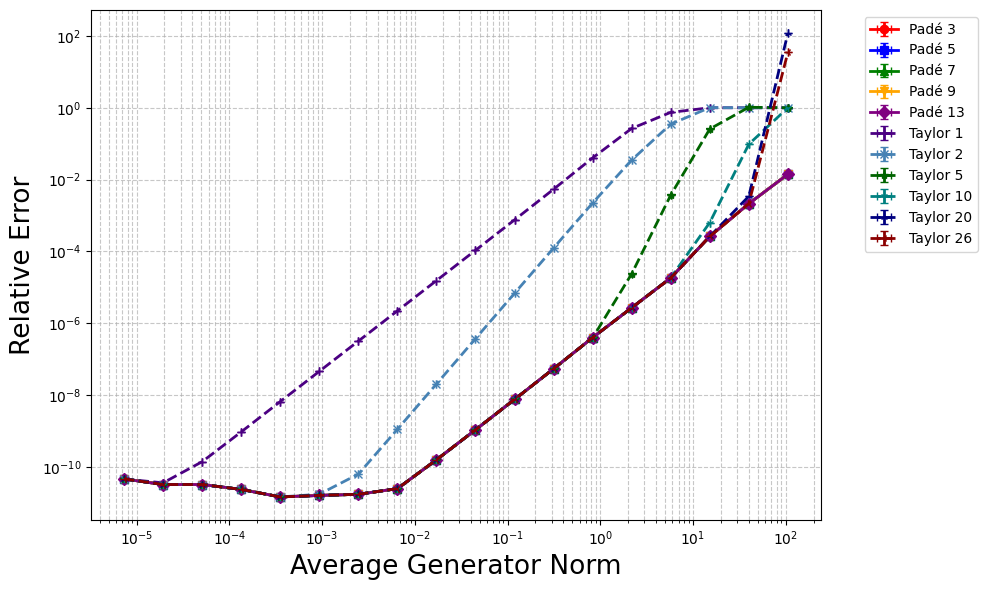

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

g_scales = jnp.logspace(-7, 1, 20)  # 0.001 to 10 in log scale
num_trials = 10

# Methods
plot_methods = [
    "Padé 3", "Padé 5", "Padé 7", "Padé 9", "Padé 13",
    "Taylor 1", "Taylor 2", "Taylor 5", "Taylor 10", "Taylor 20", "Taylor 26"
]


method_styles = {
    "Padé 3":   {'marker': 'o', 'linestyle': '-', 'color': 'red'},
    "Padé 5":   {'marker': 's', 'linestyle': '-', 'color': 'blue'},
    "Padé 7":   {'marker': '^', 'linestyle': '-', 'color': 'green'},
    "Padé 9":   {'marker': 'v', 'linestyle': '-', 'color': 'orange'},
    "Padé 13":  {'marker': 'D', 'linestyle': '-', 'color': 'purple'},
    "Taylor 1": {'marker': '+', 'linestyle': '--', 'color': 'indigo'},
    "Taylor 2": {'marker': 'x', 'linestyle': '--', 'color': 'steelblue'},
    "Taylor 5": {'marker': '*', 'linestyle': '--', 'color': 'darkgreen'},
    "Taylor 10":{'marker': '1', 'linestyle': '--', 'color': 'teal'},
    "Taylor 20":{'marker': '2', 'linestyle': '--', 'color': 'navy'},
    "Taylor 26":{'marker': '3', 'linestyle': '--', 'color': 'darkred'},
}

# Warmup
print("Warming up GPU")
for g_scale in g_scales[:2]:
    G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
    _ = euler_method(A_mats, delta_omega, h0, num_substeps=1000, g_scale=g_scale)
    for name, param in methods:
        if name in plot_methods:
            if "Padé" in name:
                _ = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale)
            elif "Taylor" in name:
                _ = model.forward(delta_omega, h0, method="taylor", taylor_order=int(param), g_scale=g_scale)
print("Warmup done.\n")

# Results
avg_norms_mean, avg_norms_std = [], []
rel_errors_mean, rel_errors_std = [], []

for g_scale in g_scales:
    trial_norms = []
    trial_errors = []

    for _ in range(num_trials):
        # Compute avg norm
        G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
        avg_norm = jnp.mean(jnp.array([jnp.max(jnp.sum(jnp.abs(G), axis=0)) for G in G_seq]))
        trial_norms.append(float(avg_norm))

        # Compute relative errors
        rel_errs = []
        h_euler_gt = euler_method(A_mats, delta_omega, h0, num_substeps=100000, g_scale=g_scale)

        for name, param in methods:
            if name not in plot_methods:
                continue
            if "Padé" in name:
                h, _ = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale)
            elif "Taylor" in name:
                h = model.forward(delta_omega, h0, method="taylor", taylor_order=int(param), g_scale=g_scale)
            rel_err = float(jnp.linalg.norm(h - h_euler_gt) / jnp.linalg.norm(h_euler_gt))
            rel_errs.append(rel_err)

        trial_errors.append(rel_errs)

    # Average + Std over trials
    avg_norms_mean.append(np.mean(trial_norms))
    avg_norms_std.append(np.std(trial_norms))

    rel_errors_mean.append(np.mean(trial_errors, axis=0))
    rel_errors_std.append(np.std(trial_errors, axis=0))

avg_norms_mean = np.array(avg_norms_mean)
avg_norms_std = np.array(avg_norms_std)
rel_errors_mean = np.array(rel_errors_mean)
rel_errors_std = np.array(rel_errors_std)

# Plot
plt.figure(figsize=(10,6))
for i, method_name in enumerate(plot_methods):
    style = method_styles.get(method_name, {'marker':'o', 'linestyle':'-', 'color': None})

    plt.errorbar(
        avg_norms_mean,
        rel_errors_mean[:, i],
        yerr=rel_errors_std[:, i],
        xerr=avg_norms_std,
        marker=style['marker'],
        linestyle=style['linestyle'],
        label=method_name,
        linewidth=2,
        color=style['color'],
        capsize=3
    )

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Average Generator Norm", fontsize=19)
plt.ylabel("Relative Error", fontsize=19)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# GPU warmup
print("Performing GPU warmup...")
key_warmup = jax.random.PRNGKey(0)
A_warmup = generate_dense_A(key_warmup, 32, 32)
t_warmup, omega_warmup, delta_warmup = generate_paths(key_warmup, 5, 32)
h0_warmup = jnp.ones(32, dtype=DTYPE_FP64)
model_warmup = LinearCDE(32, 32, A_warmup)
_ = model_warmup.forward(delta_warmup, h0_warmup, method="pade", pade_type="13")
_ = model_warmup.forward(delta_warmup, h0_warmup, method="taylor", taylor_order=10)
_ = euler_method(A_warmup, delta_warmup, h0_warmup, num_substeps=100)
print("GPU warmup completed.\n")

# Run multiple experiments
num_runs = 10
all_results = []
all_norms = []

methods = [
    ("Padé 3", "3"),
    ("Padé 5", "5"),
    ("Padé 7", "7"),
    ("Padé 9", "9"),
    ("Padé 13", "13"),
    ("Scipy", None),
    ("Taylor 1", 1),
    ("Taylor 2", 2),
    ("Taylor 5", 5),
    ("Taylor 10", 10),
    ("Taylor 20", 20),
    ("Taylor 26", 26),
    ("RK4 10", 10),
    ("RK4 100", 100),
    ("Euler 10", 10),
    ("Euler 100", 100)
]

print(f"Running {num_runs} experiments...")
for run_idx in range(num_runs):
    print(f"Run {run_idx + 1}/{num_runs}")

    # Generate new data for this run
    key = jax.random.PRNGKey(42 + run_idx)
    input_dim = 32
    hidden_dim = 32
    seq_len = 10
    d_omega = input_dim
    g_scale = 1

    key1, key2 = jax.random.split(key)
    A_mats = generate_dense_A(key1, hidden_dim, input_dim)
    t_vals, omega_vals, delta_omega = generate_paths(key2, seq_len, d_omega)
    h0 = jnp.ones(hidden_dim, dtype=DTYPE_FP64)
    model = LinearCDE(input_dim, hidden_dim, A_mats)

    # Run all methods
    results = {}
    for name, param in methods:
        t0 = time.time()
        if "Padé" in name:
            h, scales = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale)
        elif "Taylor" in name:
            h = model.forward(delta_omega, h0, method="taylor", taylor_order=int(param), g_scale=g_scale)
        elif "RK4" in name:
            h = rk4_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
        elif "Euler" in name:
            h = euler_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
        elif name=="Scipy":
            h = scipy_method(A_mats, delta_omega, h0, g_scale=g_scale)
        results[name] = (h, time.time() - t0)

    # Euler ground truth
    t0 = time.time()
    h_euler_gt = euler_method(A_mats, delta_omega, h0, num_substeps=100000, g_scale=g_scale)
    time_euler_gt = time.time() - t0

    # Compute generator matrix norms
    G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
    G_norms = jnp.array([jnp.max(jnp.sum(jnp.abs(G), axis=0)) for G in G_seq])

    # Store results
    run_results = {}
    for name, (h, t_elapsed) in results.items():
        rel_err = float(jnp.linalg.norm(h - h_euler_gt)/jnp.linalg.norm(h_euler_gt))
        run_results[name] = {'time': t_elapsed, 'rel_error': rel_err}

    run_results['Euler ground truth'] = {'time': time_euler_gt, 'rel_error': 0.0}

    all_results.append(run_results)
    all_norms.append(G_norms)

# Aggregate results
method_names = list(all_results[0].keys())
aggregated_results = {}

for method in method_names:
    times = [run[method]['time'] for run in all_results]
    rel_errors = [run[method]['rel_error'] for run in all_results]

    aggregated_results[method] = {
        'time_mean': jnp.mean(jnp.array(times)),
        'time_std': jnp.std(jnp.array(times)),
        'rel_error_mean': jnp.mean(jnp.array(rel_errors)),
        'rel_error_std': jnp.std(jnp.array(rel_errors))
    }

# Print average generator matrix norms
avg_norms = jnp.mean(jnp.array(all_norms), axis=0)
std_norms = jnp.std(jnp.array(all_norms), axis=0)
print("\nAverage norms of generator matrices at each time step (over all runs):")
for t, (norm_mean, norm_std) in enumerate(zip(avg_norms, std_norms)):
    print(f"t={t:3d}, ||G_t||_F = {norm_mean:.6e} ± {norm_std:.6e}")

# Results table
print(f"\n{'Method':<20} {'Time (s)':<20} {'Relative Error':<25}")
print("-" * 70)

for method in method_names:
    stats = aggregated_results[method]
    time_str = f"{stats['time_mean']:.6f} ± {stats['time_std']:.6f}"
    if stats['rel_error_mean'] == 0.0:
        error_str = "0.00e+00 ± 0.00e+00"
    else:
        error_str = f"{stats['rel_error_mean']:.2e} ± {stats['rel_error_std']:.2e}"

    print(f"{method:<20} {time_str:<20} {error_str:<25}")

Performing GPU warmup...
GPU warmup completed.

Running 10 experiments...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Average norms of generator matrices at each time step (over all runs):
t=  0, ||G_t||_F = 8.622672e+01 ± 1.260522e+01
t=  1, ||G_t||_F = 7.553320e+01 ± 4.786868e+00
t=  2, ||G_t||_F = 7.929553e+01 ± 9.835016e+00
t=  3, ||G_t||_F = 8.105220e+01 ± 9.456417e+00
t=  4, ||G_t||_F = 7.907355e+01 ± 1.237500e+01
t=  5, ||G_t||_F = 8.423340e+01 ± 1.075001e+01
t=  6, ||G_t||_F = 8.134498e+01 ± 1.354316e+01
t=  7, ||G_t||_F = 8.107855e+01 ± 1.431476e+01
t=  8, ||G_t||_F = 8.810304e+01 ± 1.023000e+01
t=  9, ||G_t||_F = 7.618787e+01 ± 7.028821e+00

Method               Time (s)             Relative Error           
----------------------------------------------------------------------
Padé 3               0.081760 ± 0.014002  9.61e-03 ± 4.34e-03      
Padé 5               0.101930 ± 0.009235  9.61e-03 ± 4.34e-03      
Padé 7           

/tmp/ipython-input-2701671962.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "+-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(seq_lengths, taylor_1_times, '+-', label='Taylor 1', linewidth=2, linestyle='--', color='indigo')
/tmp/ipython-input-2701671962.py:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(seq_lengths, taylor_2_times, 'x-', label='Taylor 2', linewidth=2, linestyle='--', color='steelblue')
/tmp/ipython-input-2701671962.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "*-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(seq_lengths, taylor_5_times, '*-', label='Taylor 5', linewidth=2, linestyle='--', color='darkgreen')
/tmp/ipython-input-2701671962.py:40: UserWarning:

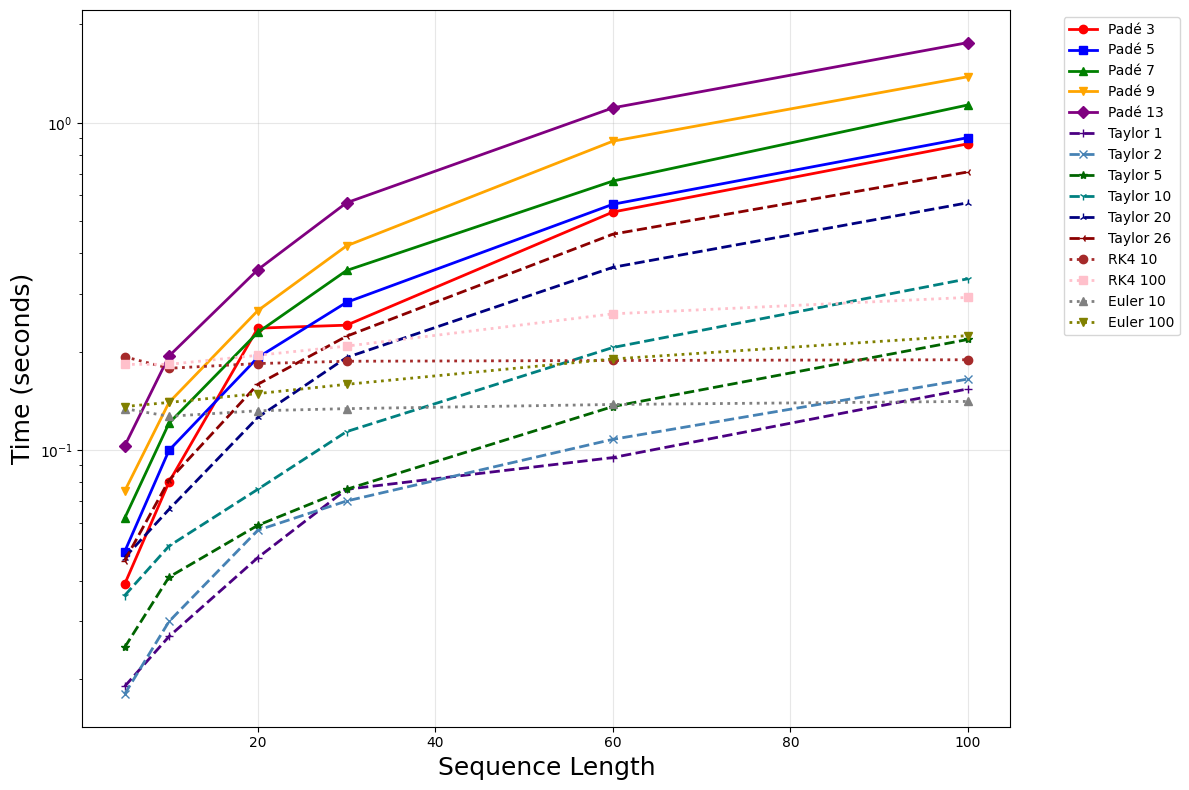

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sequence lengths
seq_lengths = [5, 10, 20, 30, 60, 100]

# Timing data obtained from running above cell for the different sequence lengths
# Series Methods
pade_3_times = [0.039, 0.080, 0.236, 0.241, 0.534, 0.863]
pade_5_times = [0.049, 0.100, 0.192, 0.283, 0.564, 0.901]
pade_7_times = [0.062, 0.121, 0.229, 0.354, 0.664, 1.134]
pade_9_times = [0.075, 0.140, 0.267, 0.421, 0.879, 1.383]
pade_13_times = [0.103, 0.194, 0.356, 0.570, 1.111, 1.758]
taylor_1_times = [0.019, 0.027, 0.047, 0.076, 0.095, 0.154]
taylor_2_times = [0.018, 0.030, 0.057, 0.070, 0.108, 0.165]
taylor_5_times = [0.025, 0.041, 0.059, 0.076, 0.136, 0.218]
taylor_10_times = [0.036, 0.051, 0.076, 0.114, 0.206, 0.334]
taylor_20_times = [0.047, 0.066, 0.126, 0.192, 0.362, 0.570]
taylor_26_times = [0.046, 0.081, 0.159, 0.223, 0.457, 0.708]

# Numerical Methods
rk4_10_times = [0.193, 0.178, 0.184, 0.187, 0.188, 0.189]
rk4_100_times = [0.183, 0.183, 0.195, 0.208, 0.261, 0.293]
euler_10_times = [0.134, 0.127, 0.132, 0.134, 0.138, 0.141]
euler_100_times = [0.136, 0.140, 0.149, 0.159, 0.190, 0.224]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot
plt.plot(seq_lengths, pade_3_times, 'o-', label='Padé 3', linewidth=2, color='red')
plt.plot(seq_lengths, pade_5_times, 's-', label='Padé 5', linewidth=2, color='blue')
plt.plot(seq_lengths, pade_7_times, '^-', label='Padé 7', linewidth=2, color='green')
plt.plot(seq_lengths, pade_9_times, 'v-', label='Padé 9', linewidth=2, color='orange')
plt.plot(seq_lengths, pade_13_times, 'D-', label='Padé 13', linewidth=2, color='purple')
plt.plot(seq_lengths, taylor_1_times, '+-', label='Taylor 1', linewidth=2, linestyle='--', color='indigo')
plt.plot(seq_lengths, taylor_2_times, 'x-', label='Taylor 2', linewidth=2, linestyle='--', color='steelblue')
plt.plot(seq_lengths, taylor_5_times, '*-', label='Taylor 5', linewidth=2, linestyle='--', color='darkgreen')
plt.plot(seq_lengths, taylor_10_times, '1-', label='Taylor 10', linewidth=2, linestyle='--', color='teal')
plt.plot(seq_lengths, taylor_20_times, '2-', label='Taylor 20', linewidth=2, linestyle='--', color='navy')
plt.plot(seq_lengths, taylor_26_times, '3-', label='Taylor 26', linewidth=2, linestyle='--', color='darkred')
plt.plot(seq_lengths, rk4_10_times, 'o-', label='RK4 10', linewidth=2, linestyle=':', color='brown')
plt.plot(seq_lengths, rk4_100_times, 's-', label='RK4 100', linewidth=2, linestyle=':', color='pink')
plt.plot(seq_lengths, euler_10_times, '^-', label='Euler 10', linewidth=2, linestyle=':', color='gray')
plt.plot(seq_lengths, euler_100_times, 'v-', label='Euler 100', linewidth=2, linestyle=':', color='olive')

# Formatting
plt.xlabel('Sequence Length', fontsize=18)
plt.ylabel('Time (seconds)', fontsize=18)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.tight_layout()
plt.show()

Sequence Length Comparison:
seq_len=20: 21 time points, avg Δt = 3.000
seq_len=60: 61 time points, avg Δt = 1.000
Resolution improvement: 3.0x finer


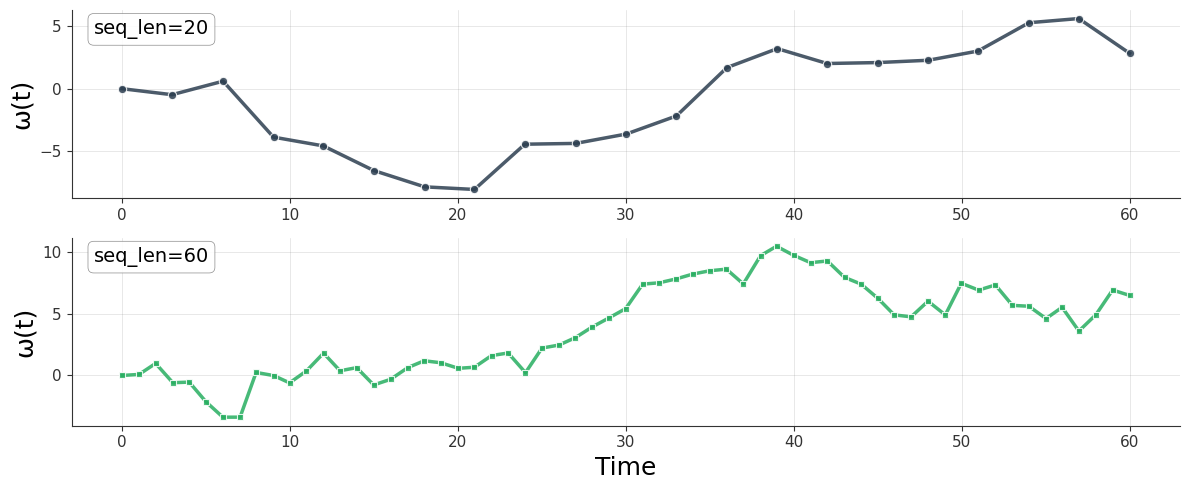

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
jax.config.update("jax_enable_x64", True)
DTYPE_FP64 = jnp.float64

def generate_paths(key, seq_len, d_omega):
    """Generate irregular time sampling and paths"""
    key1, key2 = jax.random.split(key)
    regular_times = jnp.linspace(0, 60, seq_len + 1)
    perturbations = jax.random.uniform(key1, (seq_len - 1,), minval=-0.03, maxval=0.03)
    irregular_times = jnp.sort(regular_times.at[1:-1].add(perturbations))
    dt_irregular = jnp.diff(irregular_times)
    dW = jax.random.normal(key2, (seq_len, d_omega), dtype=DTYPE_FP64) * jnp.sqrt(dt_irregular[:, None])
    omega_observed = jnp.vstack([jnp.zeros((1, d_omega), dtype=DTYPE_FP64), jnp.cumsum(dW, axis=0)])
    return irregular_times, omega_observed, dW


plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'serif']

# Generate data for two different sequence lengths
key1 = jax.random.PRNGKey(43)
key2 = jax.random.PRNGKey(116)
d_omega = 1  # 1D path

# Short sequence (20 steps)
t_short, omega_short, dW_short = generate_paths(key1, 20, d_omega)

# Long sequence (60 steps)
t_long, omega_long, dW_long = generate_paths(key2, 60, d_omega)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))
color1 = '#2C3E50'
color2 = '#27AE60'
ax1.plot(t_short, omega_short[:, 0], 'o-', color=color1, linewidth=2.5, markersize=6,
         alpha=0.85, markeredgecolor='white', markeredgewidth=0.8, zorder=3)
ax1.set_ylabel('ω(t)', fontsize=18)
ax1.text(0.02, 0.95, 'seq_len=20', transform=ax1.transAxes, fontsize=14, fontweight='normal',
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
         edgecolor='gray', alpha=0.9, linewidth=0.5))
ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#333333')
ax1.spines['bottom'].set_color('#333333')
ax1.tick_params(axis='both', which='major', labelsize=11, colors='#333333')
ax2.plot(t_long, omega_long[:, 0], 's-', color=color2, linewidth=2.5, markersize=4,
         alpha=0.85, markeredgecolor='white', markeredgewidth=0.8, zorder=2)
ax2.set_xlabel('Time', fontsize=18)
ax2.set_ylabel('ω(t)', fontsize=18)
ax2.text(0.02, 0.95, 'seq_len=60', transform=ax2.transAxes, fontsize=14, fontweight='normal',
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
         edgecolor='gray', alpha=0.9, linewidth=0.5))
ax2.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#333333')
ax2.spines['bottom'].set_color('#333333')
ax2.tick_params(axis='both', which='major', labelsize=11, colors='#333333')
plt.tight_layout()
plt.show()